1. Environment Setup

In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Embedding, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Setting up display options for better notebook readability
pd.set_option('display.max_colwidth', 200)


2. Data Loading and Preprocessing


In [4]:
import pandas as pd
import re  # Import the regular expression library

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/vaccination_all_tweets.csv')

# Basic preprocessing to clean the text
df['cleaned_text'] = df['text'].apply(lambda x: re.sub(r'http\S+', '', x))  # Remove URLs
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'@\w+', '', x))  # Remove mentions
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'\d+', '', x))  # Remove numbers
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: x.lower())  # Convert to lower case
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'\W+', ' ', x))  # Remove special characters

# Tokenization and creating sequences for training
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])


3. Exploratory Data Analysis (EDA)


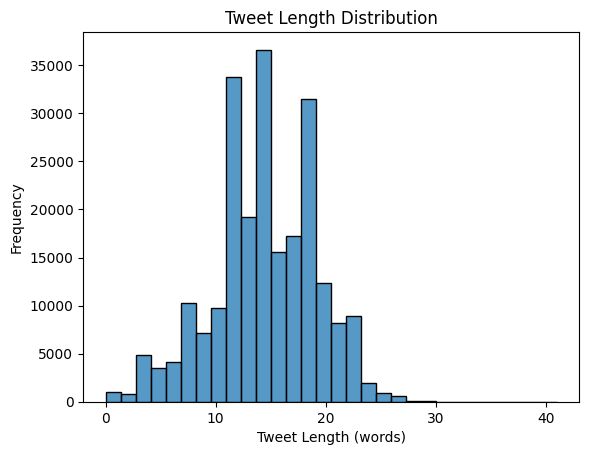

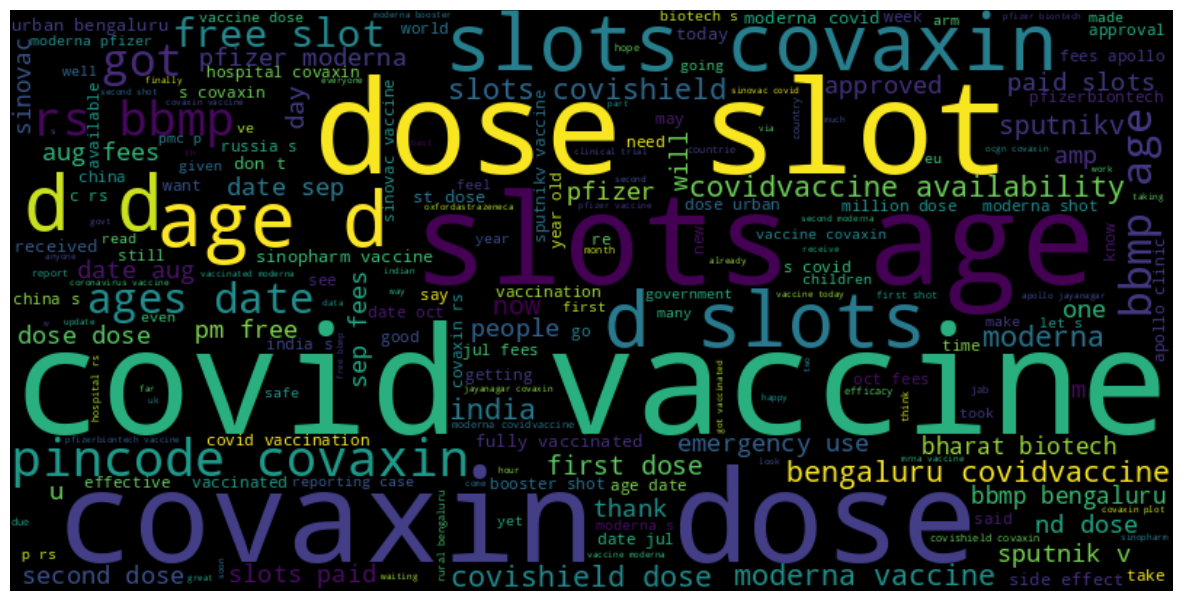

In [5]:
# Tweet length distribution
tweet_lengths = df['cleaned_text'].apply(lambda x: len(x.split()))
sns.histplot(tweet_lengths, bins=30)
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length (words)')
plt.ylabel('Frequency')
plt.show()

# Common words visualization (word cloud can be an option)
from wordcloud import WordCloud
word_cloud = WordCloud(width = 800, height = 400, random_state=21, max_font_size=110).generate(' '.join(df['cleaned_text']))
plt.figure(figsize=(15, 8))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis('off')
plt.show()


4. Model Building
Define the hybrid LSTM-GRU model architecture.

In [6]:
# Defining the hybrid model architecture
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=200))  # Adjust 'input_length' based on your data
model.add(LSTM(128, return_sequences=True))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))  # Adjust based on your output; use 'softmax' if multi-class classification

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # Adjust loss and metrics as needed


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.summary()

In [8]:
print(df.columns)

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet', 'cleaned_text'],
      dtype='object')


In [9]:
# Install nltk and download vader lexicon
!pip install nltk
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Create a sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()

# Define a function to assign labels based on compound score
def get_label(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to the cleaned text
df['sentiments'] = df['cleaned_text'].apply(lambda x: sid.polarity_scores(x))
df['label'] = df['sentiments'].apply(lambda x: get_label(x['compound']))

# Now you have a 'label' column in your dataframe
print(df[['cleaned_text', 'label']].head())


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


                                                                                                         cleaned_text  \
0                                           same folks said daikon paste could treat a cytokine storm pfizerbiontech    
1  while the world has been on the wrong side of history this year hopefully the biggest vaccination effort we ve ev    
2            coronavirus sputnikv astrazeneca pfizerbiontech moderna covid_ russian vaccine is created to last years    
3       facts are immutable senator even when you re not ethically sturdy enough to acknowledge them you were born i    
4                                  explain to me again why we need a vaccine whereareallthesickpeople pfizerbiontech    

      label  
0  positive  
1  negative  
2  positive  
3   neutral  
4   neutral  


5. Model Evaluation
Set up training and evaluation of the model.

In [10]:
from sklearn.model_selection import train_test_split

# Preparing data
X = df['cleaned_text']  # Assuming you have transformed this into sequences or embeddings as needed
y = df['label']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'cleaned_text' is your input feature and it's already cleaned
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# Padding sequences to ensure uniform input size
X = pad_sequences(sequences, maxlen=100)  # Adjust 'maxlen' to what makes sense for your data

# Now, split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

In [17]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [ ]:
# Compile your model if you haven't already done so
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Update parameters as necessary

# Fit the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 1761s 615ms/step - accuracy: 0.4635 - loss: -19.7055 - val_accuracy: 0.4654 - val_loss: -71.7423
Epoch 2/10
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 1700s 593ms/step - accuracy: 0.4658 - loss: -86.5275 - val_accuracy: 0.4654 - val_loss: -139.9262
Epoch 3/10
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.4649 - loss: -154.3593

Visualization of Results Visualize the training and validation loss and accuracy

In [ ]:
import matplotlib.pyplot as pl
# Plotting training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
